# Exploring Multiple Stimulus Perimetry Theory

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.executable

'E:\\Tools\\miniconda3\\envs\\pyvf\\python.exe'

## Bayesian Strategy: Reduction in Entropy

(array(2.77823157), array(2.76872658), array(2.98895341), array(2.98895343))

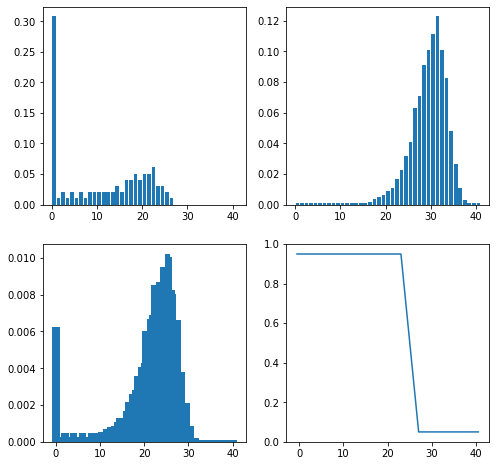

In [38]:
import pyvf.resources.turpin2003 as turpin2003
import importlib.resources as pkg_resources
from pyvf.stats import rv_histogram2
from pyvf.stats.pos import pos_ramp

with pkg_resources.open_text(turpin2003, "abnormal_pdf.csv") as f:
    abnormal_bins, abnormal_height = np.loadtxt(f, dtype=np.float32, delimiter=",", skiprows=0).T
    abnormal_bins = np.concatenate( (abnormal_bins - 0.5, [abnormal_bins[-1] + 0.5]) )
with pkg_resources.open_text(turpin2003, "normal_pdf.csv") as f:
    normal_bins, normal_height = np.loadtxt(f, dtype=np.float32, delimiter=",", skiprows=0).T
    normal_bins = np.concatenate((normal_bins - 0.5, [normal_bins[-1] + 0.5]))
    
refine_n = 10
hist_abnormal = rv_histogram2(histogram=(abnormal_height, abnormal_bins)).refined(refine_n)
hist_normal   = rv_histogram2(histogram=(  normal_height,   normal_bins)).refined(refine_n)
center_normal = hist_normal.mode()
epsilon = hist_normal.height.min()

def get_init_pdf(init_mean, coef_abnormal=0.2, coef_normal=0.8):
    return (coef_abnormal * hist_abnormal +
            coef_normal * hist_normal.roll(shift=int(round((init_mean - center_normal) * refine_n)), fill_value=epsilon))
    
fig, ax = plt.subplots(2, 2, sharex="row", sharey=False, figsize=[8, 8])
ax[0, 0].bar(abnormal_bins[1:], abnormal_height)
ax[0, 1].bar(normal_bins[1:], normal_height)
init_pdf = get_init_pdf(init_mean=25)
ax[1, 0].bar(init_pdf.bins[1:], init_pdf.height)
ax[1, 1].plot(init_pdf.bins, pos_ramp(init_pdf.bins, center=25, yl=0.95, yr=0.05, width=4))
ax[1, 1].set_ylim([0, 1])

hist_abnormal.entropy(), hist_normal.entropy(), init_pdf.entropy()

In [42]:
from pyvf.strategy import *
from pyvf.strategy.Model import *
from pyvf.strategy.Responder import *

starting_threshold = np.array([30.0, 30.0])
true_threshold = np.array([0.0, 0.0])
model = ConstantModel(eval_pattern=PATTERN_DOUBLE,
                      mean=starting_threshold,
                      std=4)  # std no effect in this case

def sim(strategy, responder):
    counter = 0
    data = []
    while True:
        stimulus, threshold = strategy.get_stimulus_threshold(data)
        if stimulus is None:
            break  # Test is finished
        else:  # isinstance(stimulus, Stimulus):  # Single stimulus perimetry
            # _logger.debug("%3d: %s\t%s", counter, threshold, stimulus)
            if isinstance(stimulus, Stimulus):
                stimulus = stimulus.copy(**{TSDISP: counter})
                stimulus = responder.get_response(stimulus)
                data.append(stimulus)
            elif isinstance(stimulus[0], Stimulus):
                stimulus = [s.copy(**{TSDISP: counter}) for s in stimulus]
                stimulus = responder.get_response(stimulus)
                data.extend(stimulus)
            else:
                raise ValueError(f"Invalid stimulus object or list of stimuli: {stimulus}")
        counter += 1
        
    return data

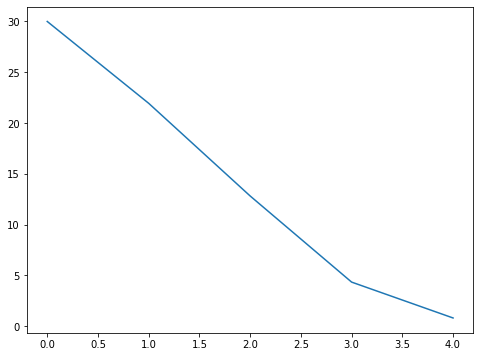

In [50]:
responder = RampResponder(true_threshold=true_threshold, fp=0, fn=0, width=0.001)
strategy = ZestStrategy(
    pattern=PATTERN_DOUBLE,
    blindspot=[],
    model=model,
    term_std=1.5,
    rng=0,
    growth_pattern=EmptyGrowthPattern()
)
data = sim(strategy, responder)
data = Stimulus.to_numpy(data)
data_loc0 = data[data['loc'] == 0]
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
ax.plot(np.arange(len(data_loc0)), data_loc0['threshold'])

### Single stimulus perimetry
Reduction in entropy for a perfect responder